# Projet IF29 P22
### Détection des influenceurs sur Twitter en appliquant les méthodes non supervisée et supervisée

In [1]:
# Créer la BD en utilisant le fichier 'Worldcup 200Tweets' sur moodle
from pymongo import MongoClient

In [ ]:
import os
import json

client = MongoClient('localhost', 27017)
db = client['______'] # nom de BD
collection = db['______'] #nom de collection
parent_dir = ("_____________________________________") #adresse de fichier
list_filename = os.listdir(parent_dir)

for filename in list_filename:
    filepath = parent_dir + filename
    with open(filepath, encoding='utf-8') as f:
        lines = f.readlines()
        f.close()
    for line in lines:
        document = json.loads(line[:-1])
        collection.insert_one(document)

In [2]:
# Connecter à la BD
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['if29']
collection = db['Tweet Worldcup 200']

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Créer le dataframe en utilisant les attributs qui nous intéressent concernant les utilisateurs

cursor = collection.aggregate(
    [
        {"$group" : {
            "_id" : "$user.id", 
            "friends_count" : {"$last" : "$user.friends_count"},
            "favourites_count" : {"$last" : "$user.favourites_count"},
            "statuses_count" : {"$last" : "$user.statuses_count"},
            "followers_count" : {"$last" : "$user.followers_count"},
             "created_time" : {"$last" : "$user.created_at"}
        }
        }
    ]
)
df = pd.json_normalize(cursor)

In [4]:
# Première analyse sur le résumé des données quantitatives
df.iloc[:,[1,2,3,4]].describe().astype(int)

,friends_count,favourites_count,statuses_count,followers_count
count,267467,267467,267467,267467
mean,1101,9108,22204,7829
std,5539,25271,54745,181738
min,0,0,1,0
25%,186,380,1329,124
50%,408,1946,6275,363
75%,906,7547,21751,1019
max,544830,1718515,8898917,30755372


In [5]:
# Calculer les indicateurs (attributs dérivés) ci-dessous destinés à la description des 'influenceurs'
# 1) Visibilité: Vis
# 2) Nombre moyen de 'aimer' par tweet: avg_fav 
# 3) Ratio entre nombre de 'abonné' et nombre de 'abonnement': r_fri_follow
# 4) la fréquence de publication de tweets depuis la création de compte jusqu'à t0 = 01/01/2019: frequency

In [5]:
# 1) Visibilité: Vis

# Regrouper les textes de tweet par chaque utilisateur
cursor1 = collection.aggregate(
    [        
         {"$group" : {
            "_id" : "$user.id", 
            
            "tweets" : {"$push": "$text"}
        }
        }
    ]
)
df1 = pd.json_normalize(cursor1)

In [6]:
def calcul_visibility(row):
    s = 0
    for tweet in row["tweets"]:
        s += tweet.count("@")*11.4  # le coût moyen pour @ est 11,4
        s += tweet.count("#")*11.6  # le coût moyen pour # est 11,6 cf.fichier 'SPOT'
    return s/(140*len(row["tweets"]))

visibilities = df1.apply(calcul_visibility,axis=1)

In [7]:
# 2) Nombre moyen de 'aimer' par tweet: avg_fav
avg_fav = df.favourites_count/df.statuses_count

In [8]:
# 3) Ratio entre nombre de 'abonné' et nombre de 'abonnement': r_fri_follow
r_fri_follow = df.followers_count/df.friends_count

In [9]:
# 4) la fréquence de publication de tweets depuis la création de compte jusqu'à t0 = 01/01/2019: frequency
import time
def ratio(row):
    time_array = time.strptime(row["created_time"], "%a %b %d %H:%M:%S +0000 %Y")
    time_stamp = time.mktime(time_array)
    time_stamp_0 = time.mktime(time.strptime("Mon Jan 1 00:00:00 2019", '%a %b %d %H:%M:%S %Y'))
    # on multiplie une constante = 100 pour amplifier les résultats
    return row["statuses_count"]*100/(time_stamp_0 - time_stamp) 

frequency = df.apply(ratio, axis=1)  

In [10]:
# Générer un dataframe en regroupant les quatres indicateurs calculés
features = pd.DataFrame()
features["user_id"] = df.iloc[:,0]
features["vis"] = visibilities
features["r_fri_follow"] = r_fri_follow
features["avg_fav"] = avg_fav
features["frequency"] = frequency

In [11]:
# On supprime toutes les lignes qui contiennent 'Nan' ou 'inf'

pd.options.mode.use_inf_as_na = True
features.dropna(inplace=True)
features = features.reset_index(drop=True)

In [14]:
# On normalise les données pour effectuer les classifications
from sklearn import preprocessing

features_normalized = preprocessing.normalize(features.iloc[:,[1,2,3,4]])
features_normalized = pd.DataFrame(features_normalized)
features_normalized.columns = ['vis','r_fri_follow','avg_fav','frequency']
features_normalized["user_id"] = features["user_id"]
features_normalized

,vis,r_fri_follow,avg_fav,frequency,user_id
0,0.059903,0.915813,0.397067,0.005987,578385417
1,0.137039,0.103644,0.985103,0.007079,840286929757327360
2,0.013439,0.990276,0.138446,0.002294,985244406
3,0.423706,0.282105,0.860750,0.000134,880421242020536320
4,0.101917,0.096089,0.990141,0.000840,3293454442
...,...,...,...,...,...
266198,0.380860,0.924630,0.000000,0.002286,979507946748104705
266199,0.146435,0.983698,0.101751,0.023287,422026094
266200,0.067663,0.948789,0.308565,0.003028,1361332098
266201,0.198209,0.876880,0.437797,0.011360,4690559857


In [24]:
# on effectue le K-means sur les données normalisées

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0) # Selon le sujet, ici on ne choisit que de classer en 2 clusters.
labels = kmeans.fit_predict(features_normalized.iloc[:,[0,1,2,3]])   

print(np.unique(labels, return_counts=True)) # afficher le résultat de séparation

(array([0, 1]), array([156715, 109488], dtype=int64))


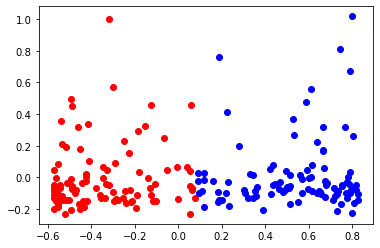

In [25]:
# On effectue l'ACP pour réduire les 4 dimensions en 2
from sklearn.decomposition import PCA

coord = PCA(n_components=2).fit_transform(features_normalized.iloc[:, [0,1,2,3]])

# projeter dans le plan factoriel avec un code couleur différent selon le groupe
# Pour être plus lisible, on trace avec 100 points pris par hasard de chaque groupe
for couleur,k in zip(['red','blue'],[0,1]):
    plt.scatter(np.random.choice(coord[kmeans.labels_==k,0],100),
                np.random.choice(coord[kmeans.labels_==k,1],100),
                c=couleur
               )

plt.show()

In [82]:
#add kmeans lebels to features
features["kmeans"] = labels
features

,user_id,vis,r_fri_follow,avg_fav,frequency,kmeans
0,885970791157960704,0.412857,0.140940,0.054364,0.015833,1
1,213953342,0.123571,0.835249,0.593961,0.005762,0
2,992050332170534913,0.116000,0.971429,0.234043,0.000449,0
3,951464137804181504,0.081429,0.190000,1.261373,0.003949,0
4,3293454442,0.206429,0.116505,1.200516,0.001019,0
...,...,...,...,...,...,...
266198,422026094,0.330000,2.216828,0.229302,0.052478,1
266199,2423474228,0.247857,1.027875,0.760796,0.005099,0
266200,600814999,0.164286,2.065846,0.034804,0.056749,0
266201,884981748207161346,0.081429,0.123188,0.309875,0.001896,0


In [15]:
# Avant de passer à l'approche supervisée, il faut d'abord labeliser les données
# Dans cette étape on va utiliser un échantillon de taille 50000 pour entraîner le modèle
# Comme on a 4 indicateurs, on décide de les combiner en utilisant la méthode d'entropie

In [84]:
# Méthode d'entropie

data = features.iloc[:,[1,2,3,4]]
indicateur = data.columns.tolist()   ## nombre des indicateurs
profil = data.index.tolist()    ## nombre des profils
value = data.values

# définir la fonction de normalisation, on rajoute une constante 0,01
def std_data(value,flag):
    for i in range(len(indicateur)):
        if flag[i]=='+':
            value[:,i]=(value[:,i]-np.min(value[:,i],axis=0))/(np.max(value[:,i],axis=0)-np.min(value[:,i],axis=0))+0.01
        elif flag[i]=='-':
            value[:,i]=(np.max(value[:,i],axis=0)-value[:,i])/(np.max(value[:,i],axis=0)-np.min(value[:,i],axis=0))+0.01
    return value

# définir la fonction d'entropie et calculer les poids et les entropies
def cal_weight(indicateur,profil,value):
    p= np.array([[0.0 for i in range(len(indicateur))] for i in range(len(profil))])                    
    for i in range(len(indicateur)):
        p[:,i]=value[:,i]/np.sum(value[:,i],axis=0)
        
    e=-1/np.log(len(profil))*sum(p*np.log(p))      #calcul d'entropie
    g=1-e     
    w=g/sum(g)     #calcul des poids
    return w

# normalisation des données
flag=["+","+","+","+"]  ## '+' ou '-' désigne le sens positif ou négatif des indicateurs
std_value=std_data(value,flag)
std_value.round(3)

# Résultat
w=cal_weight(indicateur,profil,std_value)
w=pd.DataFrame(w,index=data.columns,columns=['Poids'])
print("#######Poids:#######")
print(w)
score=np.dot(std_value,w).round(2)
score=pd.DataFrame(score,index=data.index,columns=['Notes']).sort_values(by =['Notes'],ascending = False)

# la note de chaque utilisateur représente la correspondance avec les profils qu'on va détecter
# Si une note plus élevée, le profil correspondant est plus probablement censé un influnceur

#######Poids:#######
                 Poids
vis           0.528286
r_fri_follow  0.009408
avg_fav       0.030442
frequency     0.431864


In [87]:
# A l'aide de résultat ci-dessus, on peut compter la fréquence de chaque note. Avec cela, on va ensuite calculer
# le pourcentage de fréquence cumulée. En vertu de principe de Pareto (80/20), on peut alors découper les données en 2 classes:
# les profils plus générals (la somme de fréquence représente environ 80% au total) et le reste plus critique (20%)

In [88]:
import collections
data1 = []
for i in range(266203):
    data1.append(score.iloc[i,0])

c = collections.Counter(data1) #créer un counter pour compter la fréquence de note

freq = np.array(list(dict(c).items()),dtype = 'float')

freq = freq[np.lexsort(-freq.T)] # ordonner par décroissant en fonction de fréquence

somme = 0
cumul = 0.00
cluster = []

for i in range(len(data)):
    if cumul <= 0.81:          # 0.01 de tolérance 
        somme = somme + freq[i,1].astype(int)
        cluster.append(freq[i,0])
        cumul = somme/len(score)
    else: break
    
print(cumul) # le pourcentage cumulé pour la classe 'générale'
print(cluster) #les notes de cette classe

0.8131839235470675
[0.05, 0.03, 0.07, 0.09, 0.01, 0.06, 0.04]


In [89]:
# On va maintenant labeliser les profils en fonction de classes divisées ci-dessus
label = score.apply(lambda row: 0 if row["Notes"] in cluster else 1, axis=1 )
label

141753    1
85307     1
228955    1
90331     1
227063    1
         ..
232660    0
250419    0
232664    0
118062    0
105247    0
Length: 266203, dtype: int64

In [130]:
# Application de la méthode SVM
data = features_normalized
data["label"] = label
data = data.sample(50000) # On prend un échantillon de taille 50000

X = data.iloc[:,[0,1,2,3,4]]
Y = data.iloc[:,[5]]
# X = X.to_numpy()
# Y = Y.to_numpy().ravel()

In [133]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
# On sépare les jeux d'entrâinement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)          

In [138]:
start = time.time()
svm_clf = svm.SVC(C=100, gamma=10, class_weight='balanced')
svm_clf.fit(X_train.iloc[:,[0,1,2,3]], y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

# parameters = {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.001,0.0001]}             
# svm_clf = svm.SVC()
# clf = GridSearchCV(svm_clf, parameters)
# clf.fit(X_train, y_train)
# a=pd.DataFrame(clf.cv_results_)
# a.sort_values(['mean_test_score'],ascending=False)
# print(clf.best_estimator_, clf.best_score_)

E:\Work\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training time: 114.77715182304382s


In [140]:
y_pred = svm_clf.predict(X_test.iloc[:,[0,1,2,3]])
print(accuracy_score(y_test,y_pred),'\n',classification_report(y_test,y_pred))

0.7064 
               precision    recall  f1-score   support

           0       0.90      0.72      0.80     12183
           1       0.35      0.66      0.46      2817

    accuracy                           0.71     15000
   macro avg       0.63      0.69      0.63     15000
weighted avg       0.80      0.71      0.73     15000



In [142]:
#add predict labels to X_test
X_test["pred"] = y_pred

C:\Users\Sun\AppData\Local\Temp\ipykernel_88204\1048693752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pred"] = y_pred


In [146]:
joined = X_test.merge(features, left_on="user_id", right_on="user_id")

In [147]:
joined[joined["pred"]!=joined["kmeans"]]

,vis_x,r_fri_follow_x,avg_fav_x,frequency_x,user_id,pred,vis_y,r_fri_follow_y,avg_fav_y,frequency_y,kmeans,svm
0,0.027060,0.999582,0.007092,0.007350,846591654,0,0.247143,9.129213,0.064770,0.067129,1,1
1,0.206579,0.978154,0.021207,0.009519,500543567,1,0.165714,0.784661,0.017012,0.007636,0,0
6,0.061490,0.995672,0.022366,0.066005,768185351764443136,1,0.081429,1.318519,0.029618,0.087407,0,0
10,0.491297,0.638217,0.592712,0.000167,831944239,1,0.164286,0.213415,0.198198,0.000056,0,0
12,0.284102,0.957954,0.040000,0.003265,184928650,1,0.247143,0.833333,0.034797,0.002840,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14984,0.256386,0.929161,0.265775,0.017005,318010642,1,0.164286,0.595383,0.170302,0.010896,0,0
14989,0.057794,0.998210,0.005172,0.014470,289333169,1,0.081429,1.406417,0.007287,0.020387,0,0
14990,0.728904,0.552476,0.404277,0.005400,2496562249,1,0.248571,0.188406,0.137867,0.001841,0,0
14994,0.017393,0.999390,0.029660,0.006176,450896622,0,0.248571,14.282705,0.423890,0.088267,1,0


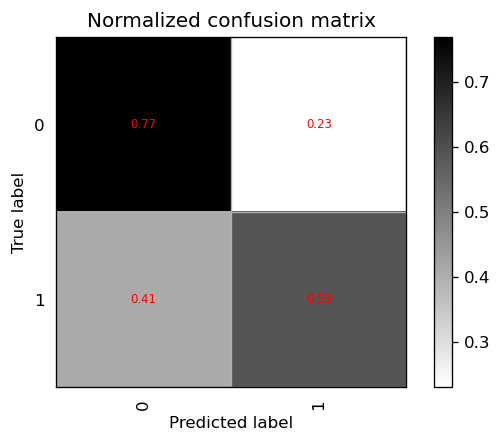

In [41]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print(cm_normalized)

tick_marks = np.array(range(2)) + 0.5###

labels=range(2)###
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(2))###
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(6, 4), dpi=120)

ind_array = np.arange(2)###
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    if c > 0.01:
        plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
# show confusion matrix
# plt.savefig('filepath')
plt.show()

In [30]:
#ROC cureve
from sklearn import metrics
from sklearn.metrics import auc

In [51]:
y_score = svm_clf.decision_function(X_test)

In [52]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)

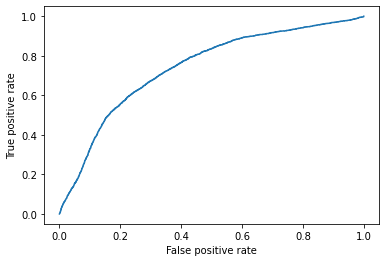

In [62]:
plt.plot(fpr,tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [61]:
AUC = auc(fpr, tpr)
print("AUC: ",AUC)

AUC:  0.7399783441526975


In [55]:
#learing curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    svm_clf, X_train, y_train, scoring='accuracy'
)

In [58]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

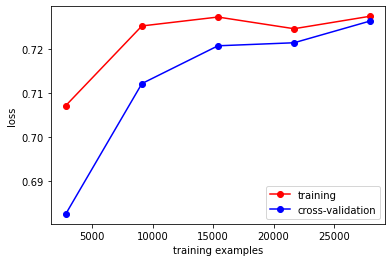

In [60]:
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='training')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='cross-validation')
plt.xlabel("training examples")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()